In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods, add_year_lines
from helpers import metrics as mc
from helpers import infodynamics

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv(cf['data_path_speech'],sep='\t',usecols=['date','speech_id','role','member-ref'])
data['date'] = pd.to_datetime(data.date,infer_datetime_format=True)

**Government Member Presence**

Linkage measures the interrelatedness of topics. Since topics are often representative of policy areas, the degree to which multiple government members are present in a debate might correlate with linkage.

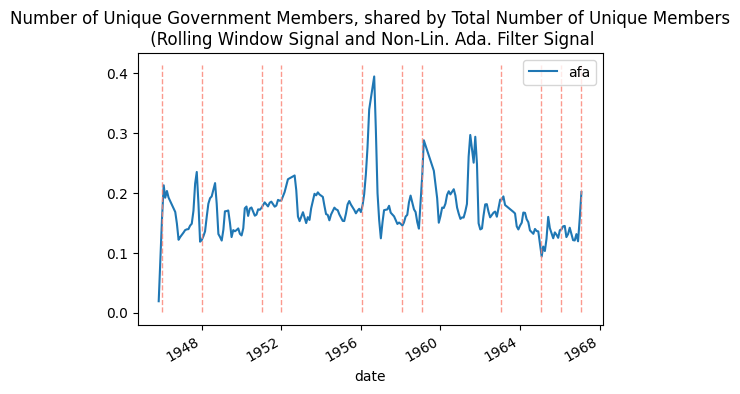

In [9]:
# Average Number of Government Members Present
gm_r_all = []

for date,dat in data.groupby(data.date.dt.to_period('M')):
    roles_unique_parts = dat[['role','member-ref']].drop_duplicates().role.tolist()
    gm_r_all.append({"date":date.to_timestamp(),"gm_uq":len([p for p in roles_unique_parts if p == 'government']) / len(roles_unique_parts)})

gm_r_all = pd.DataFrame(gm_r_all)
gm_r_all['afa'] = adaptive_filter(gm_r_all.gm_uq,span=150)

fig,ax = plt.subplots(1,1,figsize=(6,4))
gm_r_all.plot(x='date',y='afa',ax=ax)
add_cabinet_periods(ax,text=False,alpha=.8)
plt.title('Number of Unique Government Members, shared by Total Number of Unique Members\n (Rolling Window Signal and Non-Lin. Ada. Filter Signal')
# plt.savefig('figs/gov-member-ratio-month.pdf',dpi=250,bbox_inches='tight')
plt.show()

# Speaker Diversity

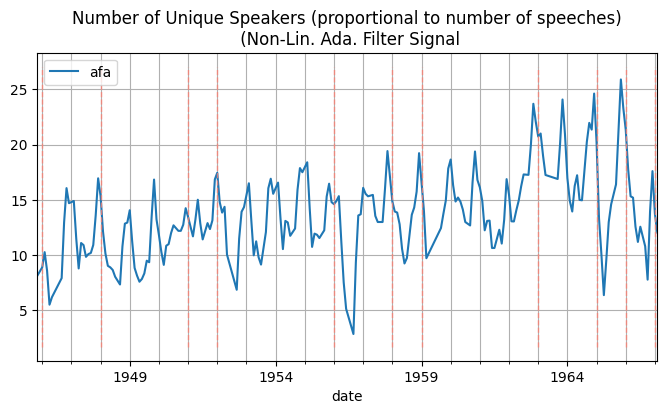

In [16]:
# Speaker Diversity
sdiv = pd.DataFrame([{"date":date,"ratio":len(dat['member-ref'].unique()) / dat.shape[1]} for date,dat in data.groupby(data.date.dt.to_period('M'))])
sdiv['afa'] = adaptive_filter(sdiv['ratio'],span=150)
fig,ax = plt.subplots(1,1,figsize=(8,4))
sdiv.plot(x='date',y='afa',ax=ax)
add_cabinet_periods(ax,text=False,alpha=.8)
plt.title('Number of Unique Speakers (proportional to number of speeches)\n (Non-Lin. Ada. Filter Signal')
plt.grid(True,which='minor')
plt.grid(True,which='major')

plt.show()